# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [1]:
import os
import ssl
from tensorflow.keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '')
        and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

An example from the reviews:
Text : Entertainment Tonight has been going down hill for the last few years, but as of last night (Aug 17th 2006) they reached a new low.<br /><br />In an effort to try to hype up their broadcast, they deci...
Label: neg


# Prepare Data
Initialize a `WordVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We won't use any word tokenizer, so the words will be splitted
on spaces and keep the `num_words` most common words.

In [2]:
from keras_nlp import WordVectorizer

num_words = 50000
word_vectorizer = WordVectorizer(num_words=num_words, oov_token='UNK')
word_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens num_words + PAD + OOV token
print(f'Vectorizer number of tokens: {word_vectorizer.num_tokens}')

2020-Apr-10 00:01:28 [INFO    :WordVectorizer] - Creating vocabulary.


25000/25000 [==============================] - 4s 172us/step
Vectorizer number of tokens: 50002


## Vectorize Data
We apply the fitted vectorizer onto the train and test texts. 

In [3]:
max_tokens = 1000
X_train = word_vectorizer.texts_to_vectors(train_texts, shape=(max_tokens,))

2020-Apr-10 00:01:32 [INFO    :WordVectorizer] - Converting texts to vectors.


25000/25000 [==============================] - 4s 168us/step


**Attention**: We *must* pass the same number of `max_tokens` when converting
different text sets. If we don't, then it is almost certain that the results
will have different numbers of columns because the set are likely to have 
different number of tokens.

In [4]:
X_test = word_vectorizer.texts_to_vectors(test_texts, shape=(max_tokens,))

2020-Apr-10 00:01:37 [INFO    :WordVectorizer] - Converting texts to vectors.


25000/25000 [==============================] - 4s 168us/step


## Decode Data
We print a decoded fragment of an encoded review as an example.

In [5]:
decoded = word_vectorizer.vectors_to_texts(X_test[:1])
print('Example fragment of a decoded review')
print('====================================')
print(decoded[0][67:76])

2020-Apr-10 00:01:42 [INFO    :WordVectorizer] - Converting vectors to texts.


1/1 [==============================] - 0s 507us/step
Example fragment of a decoded review
['he', 'she', 'is', 'wrong', 'i', 'was', 'rather', 'puzzled', 'by']


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [6]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, shuffle=True, random_state=44)

print(f'X_train: {X_train.shape}')
print(f'X_dev  : {X_val.shape}')
print(f'X_test : {X_test.shape}')

X_train: (18750, 1000)
X_dev  : (6250, 1000)
X_test : (25000, 1000)


# Neural Network
Here we define a toy network for demonstration purpose.

In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, TimeDistributed, \
    Dropout, Flatten, Dense

words_input = Input(shape=(max_tokens, ), name='Input', dtype='int32')
words_embeddings = Embedding(
    input_dim=len(word_vectorizer.token2id),
    output_dim=100,
    input_length=max_tokens,
    mask_zero=0,
    trainable=True,
    name='Embeddings')(words_input)
x = Flatten(name='Flatten')(words_embeddings)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(words_input, predictions)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
Embeddings (Embedding)       (None, 1000, 100)         5000200   
_________________________________________________________________
Flatten (Flatten)            (None, 100000)            0         
_________________________________________________________________
Predictions (Dense)          (None, 1)                 100001    
Total params: 5,100,201
Trainable params: 5,100,201
Non-trainable params: 0
_________________________________________________________________
None


## Train Model

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train,
                    y_train, 
                    batch_size=50, 
                    epochs=5, 
                    validation_data=(X_val, y_val))

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 28s 1ms/sample - loss: 0.4580 - acc: 0.7692 - val_loss: 0.2980 - val_acc: 0.8710
Epoch 2/5
18750/18750 [==============================] - 27s 1ms/sample - loss: 0.1425 - acc: 0.9529 - val_loss: 0.2680 - val_acc: 0.8899
Epoch 3/5
18750/18750 [==============================] - 28s 1ms/sample - loss: 0.0427 - acc: 0.9922 - val_loss: 0.2907 - val_acc: 0.8854
Epoch 4/5
18750/18750 [==============================] - 27s 1ms/sample - loss: 0.0144 - acc: 0.9989 - val_loss: 0.2968 - val_acc: 0.8936
Epoch 5/5
18750/18750 [==============================] - 26s 1ms/sample - loss: 0.0064 - acc: 0.9998 - val_loss: 0.3140 - val_acc: 0.8926


## Model Evaluation

In [10]:
scores = model.evaluate(X_test, y_test)
print(f'Evaluation accuracy: {100*scores[1]:.2f}%')

25000/25000 [==============================] - 4s 175us/sample - loss: 0.3323 - acc: 0.8795
Evaluation accuracy: 87.95%


# Plot Accuracy and Loss

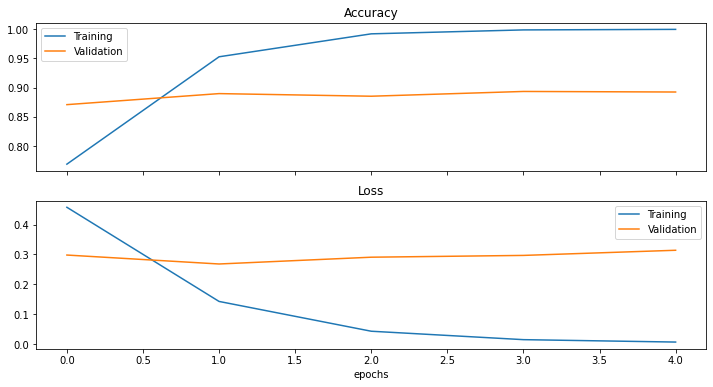

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()